# Clustering Model Selection

We run a handful of clustering algorithms and hyperparameter combinations and try to make sense of the quality of results.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

In [2]:
data = pd.read_csv('../data/features/merged.csv')
# Read in data

## Create training data
### ... by filtering rows

In [3]:
# the row filter subsets the index too. we reset it here to make it easier to concatenate the training labels later on
training_datas = {}
for year in data['YEAR'].unique():
    training_datas[year] = data.loc[data['YEAR'] == year].reset_index(drop=True)

### ... by filtering columns

In [4]:
drop_cols = ['BEAT','YEAR',
'COMPLAINTS_COMPLAINANT_RACE_BlackorAfricanAmerican',
'COMPLAINTS_COMPLAINANT_RACE_Hispanic,Latino,orSpanishOrigin',
'COMPLAINTS_COMPLAINANT_RACE_White',
'COMPLAINTS_COMPLAINANT_RACE_Other',
'CRIME_Total',
'ISR_TOTAL_COUNT',
'ISR_RACE_CODE_CD_API',
'ISR_RACE_CODE_CD_BLK',
'ISR_RACE_CODE_CD_I',
'ISR_RACE_CODE_CD_P',
'ISR_RACE_CODE_CD_U',
'ISR_RACE_CODE_CD_WBH',
'ISR_RACE_CODE_CD_WHI',
'ISR_RACE_CODE_CD_WHT',
'ISR_RACE_CODE_CD_WWH',
'ISR_CNT_HISPANIC',
'UOF_DISTRICT',
'UOF_HISPANIC',
'UOF_BLACK',
'UOF_WHITE',
'CENSUS_beat',
'CENSUS_district',
'CENSUS_sector',
'CENSUS_Total Pop',
'CENSUS_White',
'CENSUS_Black',
'CENSUS_Hispanic',
'CENSUS_Median Income']

for tdata in training_datas.values():
    tdata.drop(drop_cols, axis=1, inplace=True)




## Preprocess / transform data

In [5]:
from sklearn.preprocessing import StandardScaler
# Normalize columns
# This puts all features at same importance. We may want type or shootings to be more important somehow.
scaler = StandardScaler()
scaled_datas = {}
for year, tdata in training_datas.items():
    scaled_datas[year] = pd.DataFrame(scaler.fit_transform(tdata), \
        columns=tdata.columns)

In [6]:
from sklearn.decomposition import PCA
# Do PCA
pca = PCA()
pca_datas = {}
pca_var_ratio = {}
pca_first_component = {}
for year, sdata in scaled_datas.items():
    pca_datas[year] = pd.DataFrame(pca.fit_transform(sdata))
    pca_var_ratio[year] = pca.explained_variance_ratio_
    pca_first_component[year] = pca.components_[0,:]
pca_var_matrix = pd.DataFrame([pd.Series(v, name=str(k)) for k,v in pca_var_ratio.items()])
pca_comp_df = pd.DataFrame([pd.Series(v, name=str(k)) for k,v in pca_first_component.items()])

## Look at PCA change over time

<AxesSubplot:>

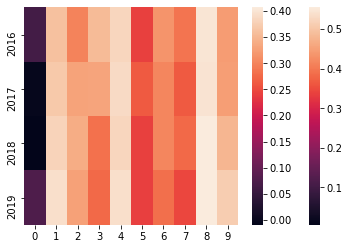

In [7]:
# I guess this is just a sanity check that the variance doesn't swing around 
sns.heatmap(pca_var_matrix)
sns.heatmap(pca_comp_df)

## Do clustering

In [8]:
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from util_clustering import grid_search_clustering

n_beats = len(data['BEAT'].unique())
min_samples = min([x.shape[0] for x in scaled_datas.values()])
n_clusters = [min(min_samples, int(2+i * n_beats / 10)) for i in range(0,10)]
params_km = {'n_clusters': n_clusters}
km_results = {}
for year, sdata in scaled_datas.items():
    km_results[year] = grid_search_clustering(KMeans(), \
        ParameterGrid(params_km), sdata, 'inertia_')
    km_results[year]['Year'] = year

km_results_df = pd.concat([x for x in km_results.values()])



Training KMeans with: {'n_clusters': 2}
Training Time Elapsed: 0:00:00.019548
Training KMeans with: {'n_clusters': 29}
Training Time Elapsed: 0:00:00.109203
Training KMeans with: {'n_clusters': 56}
Training Time Elapsed: 0:00:00.198171
Training KMeans with: {'n_clusters': 83}
Training Time Elapsed: 0:00:00.268929
Training KMeans with: {'n_clusters': 110}
Training Time Elapsed: 0:00:00.364345
Training KMeans with: {'n_clusters': 137}
Training Time Elapsed: 0:00:00.437814
Training KMeans with: {'n_clusters': 164}
Training Time Elapsed: 0:00:00.522441
Training KMeans with: {'n_clusters': 191}
Training Time Elapsed: 0:00:00.614242
Training KMeans with: {'n_clusters': 218}
Training Time Elapsed: 0:00:00.723237
Training KMeans with: {'n_clusters': 236}
Training Time Elapsed: 0:00:00.784291
Grid search completed.
Training KMeans with: {'n_clusters': 2}
Training Time Elapsed: 0:00:00.018506
Training KMeans with: {'n_clusters': 29}
Training Time Elapsed: 0:00:00.110122
Training KMeans with: {'n

### Evaluate performance

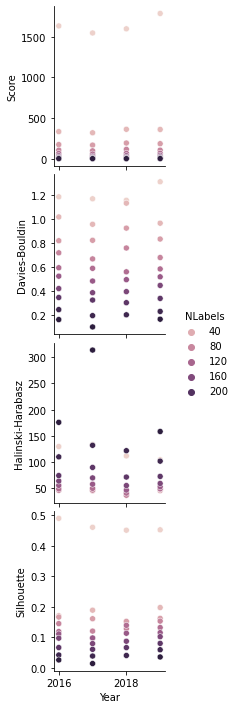

In [9]:
sns.pairplot(data=km_results_df,x_vars='Year',y_vars=['Score','Davies-Bouldin','Halinski-Harabasz','Silhouette'],hue='NLabels')

## Try to make sense of results

### ... by searching all years sizes and watching feature importance

In [10]:
from sklearn.tree import DecisionTreeClassifier

# km_results_df.NLabels.unique()
# array([2, 29, 56, 83, 110, 137, 164, 191, 218, 236], dtype=object)
# Lets pick 29 as the second smallest one
n_labels = 236
km_results_labels = {}
for year in scaled_datas.keys():
    cond = (km_results_df['Model']=='KMeans') \
           & (km_results_df['NLabels']==29) \
            & (km_results_df['Year']==year)
    labs_arr = km_results_df.loc[cond,:]\
        .sort_values(by='Score', ascending=True) \
        .head(1)['Labels'].to_numpy()[0]
    beats_arr = data.loc[data['YEAR']==year,'BEAT'].reset_index(drop=True)
    km_results_labels[year] = pd.concat([pd.Series(labs_arr,name="Labels"),\
                                        pd.Series(beats_arr,name="Beats")],axis=1)

tree = DecisionTreeClassifier()
max_clusters = max(km_results_df.NLabels.unique())
sweep_importances = {}

for year, clusters in scaled_datas.items():
    tree.fit(scaled_datas[year], km_results_labels[year]['Labels'])
    sweep_importances[year] = pd.Series(tree.feature_importances_, name=str(year))

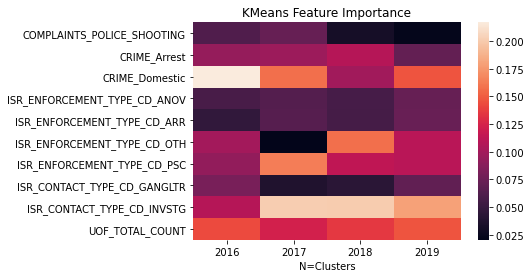

In [11]:
colors = sns.color_palette(palette='flare',n_colors=max_clusters)
sweep_importance_df = pd.DataFrame(sweep_importances)
y_cols = scaled_datas[2016].columns
sweep_importance_df_melted = sweep_importance_df \
    .assign(FEATURE = lambda x: y_cols[x.index]) \
    .melt(id_vars='FEATURE', var_name='nclusters', value_name="importance")
sns.heatmap(sweep_importance_df, yticklabels=y_cols).set(xlabel='N=Clusters', title='KMeans Feature Importance');
# This plot shows that the feature importance that this clusters on changes a lot over time, ie the clustering is pretty arbitrary

### By looking at adjacency matrix similarity

In [31]:
# Compute similarity of clustering between pairs of years
sim_matrix = []
for y1 in km_results_labels.keys():
    y1_vec = km_results_labels[y1].set_index('Beats')
    y1_adj = pd.merge(left=y1_vec,right=y1_vec, how='cross') \
        .assign(ADJ = lambda a: a['Labels_x'] == a['Labels_y'])
    y1_vec_mag = np.sqrt((y1_adj['ADJ']&y1_adj['ADJ']).sum())
    for y2 in km_results_labels.keys():
        if (y1 == y2):
            sim_matrix.append({'y1':y1, 'y2':y2, 'sim':1})
        else:
            y2_vec = km_results_labels[y2].set_index('Beats')
            print(f"Comparing years {y1} vs {y2} which is shapes {len(y1_vec)} x {len(y2_vec)}")
            y2_adj = pd.merge(left=y2_vec,right=y2_vec, how='cross') \
                .assign(ADJ = lambda a: a['Labels_x'] == a['Labels_y'])
            y2_vec_mag = np.sqrt((y2_adj['ADJ']&y2_adj['ADJ']).sum())
            sim = pd.merge(left=y1_adj, right=y2_adj, how='inner', \
                left_index=True,right_index=True) \
                .assign(SIM = lambda a: a['ADJ_x'] & a['ADJ_y'])
            sim_val = sim['SIM'].sum() / (y1_vec_mag*y2_vec_mag)
            sim_matrix.append({'y1':y1, 'y2':y2, 'sim':sim_val})
sim_df = pd.DataFrame(sim_matrix)

Comparing years 2016 vs 2017 which is shapes 249 x 241
Comparing years 2016 vs 2018 which is shapes 249 x 236
Comparing years 2016 vs 2019 which is shapes 249 x 253
Comparing years 2017 vs 2016 which is shapes 241 x 249
Comparing years 2017 vs 2018 which is shapes 241 x 236
Comparing years 2017 vs 2019 which is shapes 241 x 253
Comparing years 2018 vs 2016 which is shapes 236 x 249
Comparing years 2018 vs 2017 which is shapes 236 x 241
Comparing years 2018 vs 2019 which is shapes 236 x 253
Comparing years 2019 vs 2016 which is shapes 253 x 249
Comparing years 2019 vs 2017 which is shapes 253 x 241
Comparing years 2019 vs 2018 which is shapes 253 x 236


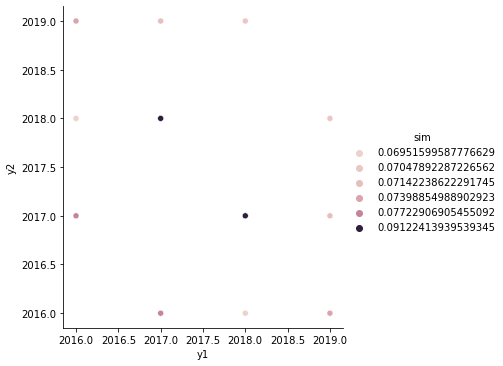

In [40]:
# Remove the diagonal since its skewing the color distribution
sim_offdiag = sim_df.loc[sim_df['y1']!=sim_df['y2'],:]
sns.relplot(data=sim_offdiag,x='y1',y='y2',hue='sim')
# So this plot/numbers are showing that year-to-year the clustering is pretty dissimilar: beats that were clustered together in one year were not likely to cluster together in another year.